In [1]:
%matplotlib inline

In [2]:
import os
import time
from collections import defaultdict

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.initializers import Constant, RandomUniform
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM, RNN
from keras.models import Sequential
from keras.utils import multi_gpu_model
# import tensorflow as tf; tf.Session(config=tf.ConfigProto(log_device_placement=True))

import nengo

from lmu import LMUCell, Legendre

Using TensorFlow backend.


In [3]:
class CapacityExperiment():
    n_gpus = 1
    data_length_factor = 2.5
    batch_size = 50
    validation_split = 0.2

    def data_sets(self, T):
        n_batches = 200
        theta = 1.0
        dt = theta / T
        freq = 10
        n_outputs = 5
        length = int(self.data_length_factor / dt + 1e-7)
        test_split = 0.5
        seed = 0
        
        rng = np.random.RandomState(seed=seed)
        process = nengo.processes.WhiteSignal(length * dt, high=freq, y0=0)

        # t = process.ntrange(length, dt=dt)
        X = np.empty((n_batches, length, 1))  # 1 input
        Y = np.zeros((n_batches, length, n_outputs))

        delay = int(theta / dt + 1e-7)
        assert T == delay
        s = np.linspace(0, delay, n_outputs, dtype=int)

        def _generate(x, y):
            x[...] = process.run_steps(length, dt=dt, rng=rng)
            x[...] /= np.max(np.abs(x))
            for i in range(n_outputs):
                y[s[i]:, i] = x[:-s[i], 0] if s[i] > 0 else x[:, 0]

        for i in range(n_batches):
            _generate(X[i, :], Y[i, :])

        cutoff = int(test_split*n_batches)

        train_X = X[:cutoff]
        train_Y = Y[:cutoff]

        test_X = X[cutoff:]
        test_Y = Y[cutoff:]

        return s, (train_X, train_Y), (test_X, test_Y)

    def make_lstm(self, units, sequence_length, output_dims):
        model = Sequential()
        model.add(LSTM(units,
                       input_shape=(sequence_length, 1),  # (timesteps, input_dims)
                       return_sequences=True))  # continuously outputs per timestep
        model.add(Dense(output_dims, activation='linear'))
        return model

    def make_lmu(self, units, sequence_length, output_dims):
        model = Sequential()
        model.add(RNN(
            LMUCell(
                units=output_dims,
                order=units,
                theta=sequence_length / self.data_length_factor - 0.5,  # nengolib/issues/169
                hidden_activation='linear',
                input_encoders_initializer=Constant(1),
                hidden_encoders_initializer=Constant(0),
                memory_encoders_initializer=Constant(0),
                trainable_input_encoders=False,
                trainable_hidden_encoders=False,
                trainable_memory_encoders=False,
                input_kernel_initializer=Constant(0),
                hidden_kernel_initializer=Constant(0),
                memory_kernel_initializer=Legendre(),
                trainable_input_kernel=False,
                trainable_hidden_kernel=False,
                trainable_memory_kernel=True,
            ),
            input_shape=(sequence_length, 1),
            return_sequences=True,
        ))
        return model

    def run(self, factory, T, epochs, units=100):
        delays, (train_X, train_Y), (test_X, test_Y) = self.data_sets(T)
        sequence_length = train_X.shape[1]
        output_dims = train_Y.shape[-1]

        model = factory(
            units=units,
            sequence_length=train_X.shape[1],
            output_dims=train_Y.shape[-1],
        )
        
        if self.n_gpus > 1:
            model = multi_gpu_model(model, gpus=self.n_gpus)

        model.compile(loss="mse", optimizer="adam")
        model.summary()

        start = time.time()
        result = model.fit(
            train_X, train_Y,
            batch_size=self.batch_size,
            epochs=epochs,
            validation_split=self.validation_split,
        )
        
        r = {}
        r['time'] = (time.time() - start) / epochs if epochs > 0 else None
        # r['model'] = model
        # r['history'] = result
        # r['test'] = model.evaluate(test_X, test_Y)
        
        hat_Y = model.predict(test_X)
        r['mses'] = np.mean((test_Y[:, T:, :] - hat_Y[:, T:, :])**2, axis=(0, 1))
        r['delays'] = delays
        
        return r

In [4]:
main = CapacityExperiment()

In [5]:
L0 = []
LT0 = [100, 1000, 10000, 100000]
for T in LT0:
    print("Running LMU0 experiments with T=%d" % T)
    L0.append(main.run(factory=main.make_lmu, T=T, epochs=0))

Running LMU0 experiments with T=100


/home/arvoelke/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/special/orthogonal.py:141: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/home/arvoelke/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/special/orthogonal.py:1977: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/arvoelke/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/special/orthogonal.py:1977: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 250, 5)            10736     
Total params: 10,736
Trainable params: 500
Non-trainable params: 10,236
_________________________________________________________________
Train on 80 samples, validate on 20 samples
Running LMU0 experiments with T=1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_2 (RNN)                  (None, 2500, 5)           10736     
Total params: 10,736
Trainable params: 500
Non-trainable params: 10,236
_________________________________________________________________
Train on 80 samples, validate on 20 samples
Running LMU0 experiments with T=10000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_3 (RNN)                  (Non

In [6]:
M = []
MT = [25, 100, 400, 1600]
ME = [500, 500, 500, 500]
for T, epochs in zip(MT, ME):
    print("Running LSTM experiments with T=%d" % T)
    M.append(main.run(factory=main.make_lstm, T=T, epochs=epochs))

Running LSTM experiments with T=25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 62, 100)           40800     
_________________________________________________________________
dense_1 (Dense)              (None, 62, 5)             505       
Total params: 41,305
Trainable params: 41,305
Non-trainable params: 0
_________________________________________________________________
Train on 80 samples, validate on 20 samples
Epoch 1/500
80/80 [==============================] - 2s 20ms/step - loss: 0.1237 - val_loss: 0.1255
Epoch 2/500
80/80 [==============================] - 0s 4ms/step - loss: 0.1226 - val_loss: 0.1243
Epoch 3/500
80/80 [==============================] - 0s 5ms/step - loss: 0.1215 - val_loss: 0.1232
Epoch 4/500
80/80 [==============================] - 0s 5ms/step - loss: 0.1203 - val_loss: 0.1220
Epoch 5/500
80/80 [==============================] - 0s 5m

80/80 [==============================] - 0s 4ms/step - loss: 0.0732 - val_loss: 0.0734
Epoch 77/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0730 - val_loss: 0.0732
Epoch 78/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0728 - val_loss: 0.0730
Epoch 79/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0727 - val_loss: 0.0728
Epoch 80/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0725 - val_loss: 0.0726
Epoch 81/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0724 - val_loss: 0.0725
Epoch 82/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0723 - val_loss: 0.0724
Epoch 83/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0723 - val_loss: 0.0722
Epoch 84/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0721 - val_loss: 0.0719
Epoch 85/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0718 - val_loss: 0.0718
Epoch 86/500


80/80 [==============================] - 0s 4ms/step - loss: 0.0616 - val_loss: 0.0603
Epoch 158/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0615 - val_loss: 0.0602
Epoch 159/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0613 - val_loss: 0.0602
Epoch 160/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0613 - val_loss: 0.0599
Epoch 161/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0611 - val_loss: 0.0598
Epoch 162/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0610 - val_loss: 0.0597
Epoch 163/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0608 - val_loss: 0.0596
Epoch 164/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0607 - val_loss: 0.0595
Epoch 165/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0606 - val_loss: 0.0593
Epoch 166/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0604 - val_loss: 0.0593
Epoc

80/80 [==============================] - 0s 4ms/step - loss: 0.0523 - val_loss: 0.0505
Epoch 239/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0521 - val_loss: 0.0504
Epoch 240/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0519 - val_loss: 0.0502
Epoch 241/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0517 - val_loss: 0.0501
Epoch 242/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0516 - val_loss: 0.0500
Epoch 243/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0501
Epoch 244/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0516 - val_loss: 0.0505
Epoch 245/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0521 - val_loss: 0.0503
Epoch 246/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0516 - val_loss: 0.0497
Epoch 247/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0494
Epoc

80/80 [==============================] - 0s 4ms/step - loss: 0.0416 - val_loss: 0.0407
Epoch 320/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0414 - val_loss: 0.0405
Epoch 321/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0412 - val_loss: 0.0403
Epoch 322/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0409 - val_loss: 0.0402
Epoch 323/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0409 - val_loss: 0.0398
Epoch 324/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0407 - val_loss: 0.0398
Epoch 325/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0405 - val_loss: 0.0397
Epoch 326/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0395
Epoch 327/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0402 - val_loss: 0.0394
Epoch 328/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0402 - val_loss: 0.0392
Epoc

80/80 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0301
Epoch 401/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0314 - val_loss: 0.0300
Epoch 402/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0313 - val_loss: 0.0299
Epoch 403/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0312 - val_loss: 0.0298
Epoch 404/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0311 - val_loss: 0.0298
Epoch 405/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0311 - val_loss: 0.0297
Epoch 406/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0309 - val_loss: 0.0293
Epoch 407/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0293
Epoch 408/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0296
Epoch 409/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0307 - val_loss: 0.0293
Epoc

80/80 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.0200
Epoch 482/500
80/80 [==============================] - 0s 5ms/step - loss: 0.0206 - val_loss: 0.0198
Epoch 483/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0198
Epoch 484/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0197
Epoch 485/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0203 - val_loss: 0.0196
Epoch 486/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0201 - val_loss: 0.0195
Epoch 487/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0201 - val_loss: 0.0196
Epoch 488/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0194
Epoch 489/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0199 - val_loss: 0.0194
Epoch 490/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0199 - val_loss: 0.0193
Epoc

80/80 [==============================] - 1s 16ms/step - loss: 0.0697 - val_loss: 0.0681
Epoch 56/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0695 - val_loss: 0.0672
Epoch 57/500
80/80 [==============================] - 1s 14ms/step - loss: 0.0690 - val_loss: 0.0672
Epoch 58/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0686 - val_loss: 0.0668
Epoch 59/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0683 - val_loss: 0.0665
Epoch 60/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0679 - val_loss: 0.0659
Epoch 61/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0676 - val_loss: 0.0655
Epoch 62/500
80/80 [==============================] - 1s 14ms/step - loss: 0.0672 - val_loss: 0.0654
Epoch 63/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0669 - val_loss: 0.0650
Epoch 64/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0665 - val_loss: 0.0647
Epo

Epoch 136/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0479 - val_loss: 0.0479
Epoch 137/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0477 - val_loss: 0.0476
Epoch 138/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0475 - val_loss: 0.0474
Epoch 139/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0472 - val_loss: 0.0472
Epoch 140/500
80/80 [==============================] - 1s 14ms/step - loss: 0.0470 - val_loss: 0.0470
Epoch 141/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0468 - val_loss: 0.0467
Epoch 142/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0465 - val_loss: 0.0464
Epoch 143/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0462 - val_loss: 0.0462
Epoch 144/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0460 - val_loss: 0.0458
Epoch 145/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0456

80/80 [==============================] - 1s 17ms/step - loss: 0.0378 - val_loss: 0.0375
Epoch 217/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0377 - val_loss: 0.0375
Epoch 218/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0376 - val_loss: 0.0374
Epoch 219/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0375 - val_loss: 0.0371
Epoch 220/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0373 - val_loss: 0.0370
Epoch 221/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0372 - val_loss: 0.0368
Epoch 222/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0371 - val_loss: 0.0369
Epoch 223/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0373 - val_loss: 0.0368
Epoch 224/500
80/80 [==============================] - 1s 14ms/step - loss: 0.0370 - val_loss: 0.0364
Epoch 225/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0368 - val_loss: 0

80/80 [==============================] - 1s 15ms/step - loss: 0.0286 - val_loss: 0.0278
Epoch 297/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0285 - val_loss: 0.0278
Epoch 298/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0285 - val_loss: 0.0277
Epoch 299/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0284 - val_loss: 0.0277
Epoch 300/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0283 - val_loss: 0.0276
Epoch 301/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0283 - val_loss: 0.0276
Epoch 302/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0282 - val_loss: 0.0275
Epoch 303/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0282 - val_loss: 0.0275
Epoch 304/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0281 - val_loss: 0.0274
Epoch 305/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0281 - val_loss: 0

80/80 [==============================] - 1s 16ms/step - loss: 0.0243 - val_loss: 0.0232
Epoch 377/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0242 - val_loss: 0.0231
Epoch 378/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0242 - val_loss: 0.0230
Epoch 379/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0241 - val_loss: 0.0230
Epoch 380/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0240 - val_loss: 0.0229
Epoch 381/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0240 - val_loss: 0.0228
Epoch 382/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0239 - val_loss: 0.0227
Epoch 383/500
80/80 [==============================] - 1s 14ms/step - loss: 0.0238 - val_loss: 0.0227
Epoch 384/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0238 - val_loss: 0.0226
Epoch 385/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0237 - val_loss: 0

80/80 [==============================] - 1s 15ms/step - loss: 0.0198 - val_loss: 0.0186
Epoch 457/500
80/80 [==============================] - 1s 16ms/step - loss: 0.0196 - val_loss: 0.0193
Epoch 458/500
80/80 [==============================] - 1s 13ms/step - loss: 0.0200 - val_loss: 0.0190
Epoch 459/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0202 - val_loss: 0.0185
Epoch 460/500
80/80 [==============================] - 1s 15ms/step - loss: 0.0200 - val_loss: 0.0216
Epoch 461/500
80/80 [==============================] - 1s 18ms/step - loss: 0.0221 - val_loss: 0.0244
Epoch 462/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0246 - val_loss: 0.0249
Epoch 463/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0244 - val_loss: 0.0275
Epoch 464/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 465/500
80/80 [==============================] - 1s 17ms/step - loss: 0.0269 - val_loss: 0

80/80 [==============================] - 3s 42ms/step - loss: 0.0814 - val_loss: 0.0866
Epoch 31/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0814 - val_loss: 0.0866
Epoch 32/500
80/80 [==============================] - 3s 41ms/step - loss: 0.0814 - val_loss: 0.0866
Epoch 33/500
80/80 [==============================] - 5s 62ms/step - loss: 0.0814 - val_loss: 0.0865
Epoch 34/500
80/80 [==============================] - 5s 63ms/step - loss: 0.0814 - val_loss: 0.0865
Epoch 35/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0814 - val_loss: 0.0865
Epoch 36/500
80/80 [==============================] - 4s 51ms/step - loss: 0.0814 - val_loss: 0.0865
Epoch 37/500
80/80 [==============================] - 5s 64ms/step - loss: 0.0814 - val_loss: 0.0865
Epoch 38/500
80/80 [==============================] - 4s 52ms/step - loss: 0.0814 - val_loss: 0.0865
Epoch 39/500
80/80 [==============================] - 4s 45ms/step - loss: 0.0813 - val_loss: 0.0865
Epo

80/80 [==============================] - 3s 39ms/step - loss: 0.0811 - val_loss: 0.0863
Epoch 112/500
80/80 [==============================] - 3s 38ms/step - loss: 0.0811 - val_loss: 0.0863
Epoch 113/500
80/80 [==============================] - 4s 44ms/step - loss: 0.0811 - val_loss: 0.0863
Epoch 114/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0811 - val_loss: 0.0863
Epoch 115/500
80/80 [==============================] - 3s 40ms/step - loss: 0.0811 - val_loss: 0.0863
Epoch 116/500
80/80 [==============================] - 4s 56ms/step - loss: 0.0811 - val_loss: 0.0862
Epoch 117/500
80/80 [==============================] - 4s 53ms/step - loss: 0.0811 - val_loss: 0.0862
Epoch 118/500
80/80 [==============================] - 4s 47ms/step - loss: 0.0810 - val_loss: 0.0862
Epoch 119/500
80/80 [==============================] - 3s 35ms/step - loss: 0.0810 - val_loss: 0.0862
Epoch 120/500
80/80 [==============================] - 3s 43ms/step - loss: 0.0810 - val_loss: 0

80/80 [==============================] - 3s 33ms/step - loss: 0.0743 - val_loss: 0.0791
Epoch 192/500
80/80 [==============================] - 5s 57ms/step - loss: 0.0742 - val_loss: 0.0788
Epoch 193/500
80/80 [==============================] - 3s 34ms/step - loss: 0.0740 - val_loss: 0.0788
Epoch 194/500
80/80 [==============================] - 3s 32ms/step - loss: 0.0739 - val_loss: 0.0789
Epoch 195/500
80/80 [==============================] - 3s 33ms/step - loss: 0.0740 - val_loss: 0.0792
Epoch 196/500
80/80 [==============================] - 3s 43ms/step - loss: 0.0740 - val_loss: 0.0789
Epoch 197/500
80/80 [==============================] - 3s 41ms/step - loss: 0.0739 - val_loss: 0.0790
Epoch 198/500
80/80 [==============================] - 3s 42ms/step - loss: 0.0740 - val_loss: 0.0788
Epoch 199/500
80/80 [==============================] - 4s 48ms/step - loss: 0.0739 - val_loss: 0.0787
Epoch 200/500
80/80 [==============================] - 4s 54ms/step - loss: 0.0738 - val_loss: 0

80/80 [==============================] - 4s 54ms/step - loss: 0.0741 - val_loss: 0.0778
Epoch 272/500
80/80 [==============================] - 5s 58ms/step - loss: 0.0735 - val_loss: 0.0787
Epoch 273/500
80/80 [==============================] - 4s 47ms/step - loss: 0.0743 - val_loss: 0.0794
Epoch 274/500
80/80 [==============================] - 4s 50ms/step - loss: 0.0740 - val_loss: 0.0795
Epoch 275/500
80/80 [==============================] - 3s 43ms/step - loss: 0.0738 - val_loss: 0.0781
Epoch 276/500
80/80 [==============================] - 5s 57ms/step - loss: 0.0732 - val_loss: 0.0777
Epoch 277/500
80/80 [==============================] - 4s 47ms/step - loss: 0.0728 - val_loss: 0.0774
Epoch 278/500
80/80 [==============================] - 4s 56ms/step - loss: 0.0726 - val_loss: 0.0777
Epoch 279/500
80/80 [==============================] - 3s 42ms/step - loss: 0.0728 - val_loss: 0.0770
Epoch 280/500
80/80 [==============================] - 5s 59ms/step - loss: 0.0722 - val_loss: 0

80/80 [==============================] - 5s 66ms/step - loss: 0.0668 - val_loss: 0.0704
Epoch 352/500
80/80 [==============================] - 5s 58ms/step - loss: 0.0668 - val_loss: 0.0699
Epoch 353/500
80/80 [==============================] - 4s 45ms/step - loss: 0.0666 - val_loss: 0.0698
Epoch 354/500
80/80 [==============================] - 5s 58ms/step - loss: 0.0665 - val_loss: 0.0699
Epoch 355/500
80/80 [==============================] - 5s 64ms/step - loss: 0.0667 - val_loss: 0.0701
Epoch 356/500
80/80 [==============================] - 3s 31ms/step - loss: 0.0665 - val_loss: 0.0697
Epoch 357/500
80/80 [==============================] - 4s 47ms/step - loss: 0.0664 - val_loss: 0.0698
Epoch 358/500
80/80 [==============================] - 2s 30ms/step - loss: 0.0663 - val_loss: 0.0696
Epoch 359/500
80/80 [==============================] - 4s 48ms/step - loss: 0.0663 - val_loss: 0.0698
Epoch 360/500
80/80 [==============================] - 4s 51ms/step - loss: 0.0663 - val_loss: 0

80/80 [==============================] - 4s 46ms/step - loss: 0.0644 - val_loss: 0.0671
Epoch 432/500
80/80 [==============================] - 3s 43ms/step - loss: 0.0644 - val_loss: 0.0669
Epoch 433/500
80/80 [==============================] - 3s 38ms/step - loss: 0.0642 - val_loss: 0.0669
Epoch 434/500
80/80 [==============================] - 3s 41ms/step - loss: 0.0642 - val_loss: 0.0667
Epoch 435/500
80/80 [==============================] - 3s 33ms/step - loss: 0.0641 - val_loss: 0.0667
Epoch 436/500
80/80 [==============================] - 4s 45ms/step - loss: 0.0640 - val_loss: 0.0666
Epoch 437/500
80/80 [==============================] - 3s 41ms/step - loss: 0.0640 - val_loss: 0.0666
Epoch 438/500
80/80 [==============================] - 4s 54ms/step - loss: 0.0639 - val_loss: 0.0665
Epoch 439/500
80/80 [==============================] - 4s 56ms/step - loss: 0.0639 - val_loss: 0.0664
Epoch 440/500
80/80 [==============================] - 3s 44ms/step - loss: 0.0638 - val_loss: 0

Epoch 5/500
80/80 [==============================] - 9s 117ms/step - loss: 0.0868 - val_loss: 0.0870
Epoch 6/500
80/80 [==============================] - 12s 155ms/step - loss: 0.0853 - val_loss: 0.0882
Epoch 7/500
80/80 [==============================] - 12s 146ms/step - loss: 0.0867 - val_loss: 0.0879
Epoch 8/500
80/80 [==============================] - 8s 104ms/step - loss: 0.0861 - val_loss: 0.0866
Epoch 9/500
80/80 [==============================] - 13s 162ms/step - loss: 0.0850 - val_loss: 0.0863
Epoch 10/500
80/80 [==============================] - 11s 132ms/step - loss: 0.0848 - val_loss: 0.0864
Epoch 11/500
80/80 [==============================] - 9s 113ms/step - loss: 0.0849 - val_loss: 0.0866
Epoch 12/500
80/80 [==============================] - 13s 158ms/step - loss: 0.0850 - val_loss: 0.0866
Epoch 13/500
80/80 [==============================] - 14s 180ms/step - loss: 0.0849 - val_loss: 0.0864
Epoch 14/500
80/80 [==============================] - 13s 162ms/step - loss: 0.08

Epoch 85/500
80/80 [==============================] - 11s 135ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 86/500
80/80 [==============================] - 13s 162ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 87/500
80/80 [==============================] - 9s 109ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 88/500
80/80 [==============================] - 14s 176ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 89/500
80/80 [==============================] - 8s 106ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 90/500
80/80 [==============================] - 14s 179ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 91/500
80/80 [==============================] - 9s 114ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 92/500
80/80 [==============================] - 10s 126ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 93/500
80/80 [==============================] - 12s 152ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 94/500
80/80 [==============================] - 7s 90ms/step - loss: 0

80/80 [==============================] - 9s 118ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 165/500
80/80 [==============================] - 10s 121ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 166/500
80/80 [==============================] - 11s 140ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 167/500
80/80 [==============================] - 12s 155ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 168/500
80/80 [==============================] - 9s 110ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 169/500
80/80 [==============================] - 14s 173ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 170/500
80/80 [==============================] - 10s 128ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 171/500
80/80 [==============================] - 11s 136ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 172/500
80/80 [==============================] - 11s 138ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 173/500
80/80 [==============================] - 9s 115ms/step - loss: 0.0

80/80 [==============================] - 12s 155ms/step - loss: 0.0840 - val_loss: 0.0855
Epoch 244/500
80/80 [==============================] - 10s 126ms/step - loss: 0.0841 - val_loss: 0.0854
Epoch 245/500
80/80 [==============================] - 9s 107ms/step - loss: 0.0840 - val_loss: 0.0854
Epoch 246/500
80/80 [==============================] - 9s 117ms/step - loss: 0.0840 - val_loss: 0.0855
Epoch 247/500
80/80 [==============================] - 10s 124ms/step - loss: 0.0840 - val_loss: 0.0856
Epoch 248/500
80/80 [==============================] - 14s 173ms/step - loss: 0.0840 - val_loss: 0.0856
Epoch 249/500
80/80 [==============================] - 8s 104ms/step - loss: 0.0839 - val_loss: 0.0854
Epoch 250/500
80/80 [==============================] - 8s 102ms/step - loss: 0.0839 - val_loss: 0.0853
Epoch 251/500
80/80 [==============================] - 9s 112ms/step - loss: 0.0839 - val_loss: 0.0852
Epoch 252/500
80/80 [==============================] - 9s 113ms/step - loss: 0.0839

80/80 [==============================] - 9s 109ms/step - loss: 0.0838 - val_loss: 0.0850
Epoch 323/500
80/80 [==============================] - 11s 137ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 324/500
80/80 [==============================] - 16s 197ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 325/500
80/80 [==============================] - 13s 167ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 326/500
80/80 [==============================] - 10s 128ms/step - loss: 0.0838 - val_loss: 0.0850
Epoch 327/500
80/80 [==============================] - 15s 183ms/step - loss: 0.0838 - val_loss: 0.0850
Epoch 328/500
80/80 [==============================] - 14s 173ms/step - loss: 0.0838 - val_loss: 0.0850
Epoch 329/500
80/80 [==============================] - 9s 118ms/step - loss: 0.0838 - val_loss: 0.0850
Epoch 330/500
80/80 [==============================] - 11s 139ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 331/500
80/80 [==============================] - 12s 153ms/step - loss: 0.

80/80 [==============================] - 11s 143ms/step - loss: 0.0843 - val_loss: 0.0860
Epoch 402/500
80/80 [==============================] - 14s 171ms/step - loss: 0.0843 - val_loss: 0.0860
Epoch 403/500
80/80 [==============================] - 9s 112ms/step - loss: 0.0843 - val_loss: 0.0860
Epoch 404/500
80/80 [==============================] - 14s 171ms/step - loss: 0.0843 - val_loss: 0.0860
Epoch 405/500
80/80 [==============================] - 12s 148ms/step - loss: 0.0842 - val_loss: 0.0860
Epoch 406/500
80/80 [==============================] - 13s 165ms/step - loss: 0.0842 - val_loss: 0.0859
Epoch 407/500
80/80 [==============================] - 9s 109ms/step - loss: 0.0842 - val_loss: 0.0859
Epoch 408/500
80/80 [==============================] - 9s 108ms/step - loss: 0.0842 - val_loss: 0.0858
Epoch 409/500
80/80 [==============================] - 11s 135ms/step - loss: 0.0842 - val_loss: 0.0858
Epoch 410/500
80/80 [==============================] - 9s 108ms/step - loss: 0.08

80/80 [==============================] - 8s 97ms/step - loss: 0.0838 - val_loss: 0.0852
Epoch 481/500
80/80 [==============================] - 13s 158ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 482/500
80/80 [==============================] - 12s 144ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 483/500
80/80 [==============================] - 14s 177ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 484/500
80/80 [==============================] - 9s 115ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 485/500
80/80 [==============================] - 9s 113ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 486/500
80/80 [==============================] - 10s 131ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 487/500
80/80 [==============================] - 11s 135ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 488/500
80/80 [==============================] - 9s 115ms/step - loss: 0.0838 - val_loss: 0.0851
Epoch 489/500
80/80 [==============================] - 12s 155ms/step - loss: 0.083

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

LSTM took 0.352852 sec/epoch on T=25
LSTM took 1.234265 sec/epoch on T=100
LSTM took 3.744452 sec/epoch on T=400
LSTM took 10.741795 sec/epoch on T=1600


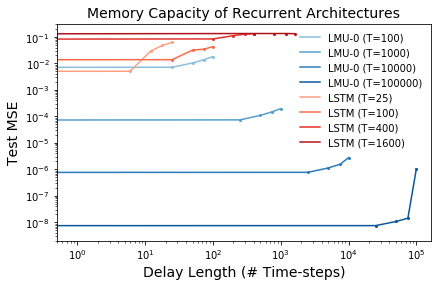

In [15]:
figname = os.path.join(os.path.abspath(""), "../figures", "capacity.pdf")

plt.figure(figsize=(6.7, 4))
plt.title("Memory Capacity of Recurrent Architectures", fontsize=14)
for name, R, T, C in (
        ('LMU-0', L0, LT0, sns.color_palette("Blues", len(L0)+2)[2:]),
        ('LSTM', M, MT, sns.color_palette("Reds", len(M)+1)[1:]),
        ):
    for r, t, c in zip(R, T, C):
        n_outputs = len(r['mses'])
        x, y = r['delays'], r['mses']
        plt.plot(x, y, c=c, label='%s (T=%d)' % (name, t))
        plt.scatter(x, y, c=c, s=4)
        if r['time'] is not None:
            print("%s took %f sec/epoch on T=%d" % (
                name, r['time'], t))
plt.xlabel("Delay Length (# Time-steps)", fontsize=14)
plt.ylabel("Test MSE", fontsize=14)
plt.legend(loc='upper right', framealpha=0)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.5, plt.xlim()[1])

plt.savefig(figname, bbox_inches='tight')

plt.show()